In [1]:
import os
from pyspark.sql import SparkSession, DataFrame, Window
from pyspark import SparkConf
from pyspark.sql.functions import (
    col, lit, sum, mean, when,
    explode, count, desc, floor,
    corr, array_contains, lit, first,
    hour
)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def create_spark_configuration() -> SparkConf:
    """
    Создает и конфигурирует экземпляр SparkConf для приложения Spark.

    Returns:
        SparkConf: Настроенный экземпляр SparkConf.
    """
    # Получаем имя пользователя
    user_name = os.getenv("USER")
    
    conf = SparkConf()
    conf.setAppName("lab 1 Test")
    conf.setMaster("yarn")
    conf.set("spark.submit.deployMode", "client")
    conf.set("spark.executor.memory", "12g")
    conf.set("spark.executor.cores", "8")
    conf.set("spark.executor.instances", "2")
    conf.set("spark.driver.memory", "4g")
    conf.set("spark.driver.cores", "2")
    conf.set("spark.jars.packages", "org.apache.iceberg:iceberg-spark-runtime-3.5_2.12:1.6.0")
    conf.set("spark.sql.extensions", "org.apache.iceberg.spark.extensions.IcebergSparkSessionExtensions")
    conf.set("spark.sql.catalog.spark_catalog", "org.apache.iceberg.spark.SparkCatalog")
    conf.set("spark.sql.catalog.spark_catalog.type", "hadoop")
    conf.set("spark.sql.catalog.spark_catalog.warehouse", f"hdfs:///user/{user_name}/warehouse")
    conf.set("spark.sql.catalog.spark_catalog.io-impl", "org.apache.iceberg.hadoop.HadoopFileIO")

    return conf

In [3]:
conf = create_spark_configuration()

In [4]:
spark = SparkSession.builder.config(conf=conf).getOrCreate()
spark

:: loading settings :: url = jar:file:/opt/spark-3.5.2-bin-hadoop3/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/user1/.ivy2/cache
The jars for the packages stored in: /home/user1/.ivy2/jars
org.apache.iceberg#iceberg-spark-runtime-3.5_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-576c4bc8-28cc-4313-bf24-40424590b37c;1.0
	confs: [default]
	found org.apache.iceberg#iceberg-spark-runtime-3.5_2.12;1.6.0 in central
:: resolution report :: resolve 626ms :: artifacts dl 25ms
	:: modules in use:
	org.apache.iceberg#iceberg-spark-runtime-3.5_2.12;1.6.0 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   1   |   0   |   0   |   0   ||   1   |   0   |
	---------------------------------------------------------------------
:: retrieving :: org.apache.spa

In [5]:
database_name = "lopin_database1"

In [6]:
spark.catalog.setCurrentDatabase(database_name)

In [7]:
df = spark.table("sobd_lab1_table")

In [8]:
df.show()

+--------------------+----------+----------+--------------------+--------+------+
|          event_time|event_type|product_id|       category_code|   brand| price|
+--------------------+----------+----------+--------------------+--------+------+
|2019-10-08 18:00:...|      view|  13900050|construction.comp...|rubineta| 36.04|
|2019-10-08 18:00:...|      view|  12700716|                NULL|  nokian| 40.93|
|2019-10-08 18:00:...|      view|  44400003|       apparel.jeans|    NULL| 46.08|
|2019-10-08 18:00:...|      view|  41900001|appliances.enviro...|    NULL|  59.2|
|2019-10-08 18:00:...|      view|   1004837|electronics.smart...|  xiaomi|323.02|
|2019-10-08 18:00:...|      view|  12703415|                NULL|cordiant| 48.91|
|2019-10-08 18:00:...|      view|  25001307|furniture.univers...|preciosa|491.71|
|2019-10-08 18:00:...|      view|   1004775|electronics.smart...|  xiaomi|180.91|
|2019-10-08 18:00:...|      view|  12706903|                NULL|  viatti| 35.91|
|2019-10-08 18:0

In [9]:
df.printSchema()

root
 |-- event_time: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: float (nullable = true)



In [10]:
df.count()

42448764

In [11]:
def plot_cat_distribution(data: DataFrame,
                          column_name: str,
                          top_n: int = 20) -> None:
    """
    Построение распределения категориального признака.

    Args:
        data (DataFrame): DataFrame, содержащий данные.
        column_name (str): Имя столбца для группировки.
        top_n (int): Количество топ-значений для отображения.
    
    Returns:
        None
    """
    # Группировка данных по столбцу и подсчет количества
    categories = (
        data
        .groupBy(column_name)
        .count()
        .orderBy("count", ascending=False)
    )
    
    print(f"Количество категорий признака {column_name}: {categories.count()}")

    categories = (
        categories
        .limit(top_n)
        .toPandas()
    )
    
    # Визуализация с использованием Seaborn
    plt.figure(figsize=(10, 6))
    sns.barplot(x=column_name, y="count", data=categories)
    plt.title(f"Barplot of \"{column_name}\" counts")
    plt.xlabel(column_name)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

In [12]:
def count_nulls(data: DataFrame,
                column_name: str) -> None:
    """
    Подсчет количества null и not null значений в указанном столбце.

    Args:
        data (DataFrame): DataFrame, содержащий данные.
        column_name (str): Имя столбца для подсчета null и not null значений.
    
    Returns:
        None
    """
    # Подсчет количества null значений в указанном столбце
    null_counts = data.select(
        sum(col(column_name).isNull().cast("int"))
    ).collect()[0][0]

    # Подсчет количества not null значений в указанном столбце
    not_null_counts = data.select(
        sum(col(column_name).isNotNull().cast("int"))
    ).collect()[0][0]

    # Вывод результатов
    print(f"Число колонок с NULL: {null_counts} "
          f"({100 * null_counts / (null_counts + not_null_counts):.2f}%)")

Убрал пропуски в category_code

In [14]:
count_nulls(data=df, column_name="category_code")


Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:409)
	at java.net.ServerSocket.implAccept(ServerSocket.java:560)
	at java.net.ServerSocket.accept(ServerSocket.java:528)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:65)


Число колонок с NULL: 13515609 (31.84%)


In [15]:
df = df.fillna({"category_code": "Unknown"})
count_nulls(data=df, column_name="category_code")

Число колонок с NULL: 0 (0.00%)


In [16]:
(
    df
    .groupBy("product_id")
    .count()
    .show()
)

+----------+------+
|product_id| count|
+----------+------+
|   1004739|150870|
|  43300024|   221|
|   1305803|   496|
|   1005158| 23136|
|  17200066|   481|
|   2900626|  1175|
|   1307184|  1431|
|  18000139|    24|
|   1201512|  2566|
|   6200373|   617|
|  27200831|     5|
|  22200112|   139|
|  12300850|  2603|
|  28100913|  2404|
|   1004666|  3472|
|  26203884|    43|
|  26500465|  1434|
|   8700252|   413|
|  49100029|   114|
|   2900536| 19183|
+----------+------+
only showing top 20 rows



In [18]:
count_df = df.groupBy("product_id").agg(count("product_id").alias("amount"))
result_df = df.join(count_df, on="product_id", how="left")



+----------+--------------------+----------+--------------------+---------+------+------+
|product_id|          event_time|event_type|       category_code|    brand| price|amount|
+----------+--------------------+----------+--------------------+---------+------+------+
|   1004739|2019-10-11 17:14:...|      view|electronics.smart...|   xiaomi|188.02|150870|
|   1004739|2019-10-10 10:15:...|      view|electronics.smart...|   xiaomi|189.67|150870|
|   1004739|2019-10-19 18:24:...|      view|electronics.smart...|   xiaomi|191.77|150870|
|   1004867|2019-10-04 08:50:...|      view|electronics.smart...|   xiaomi|452.75| 11023|
|   1005008|2019-10-02 14:26:...|      view|electronics.smart...|   xiaomi| 99.75| 71492|
|   1005011|2019-10-01 00:00:...|      view|electronics.smart...|  samsung|900.64|  1216|
|   1005031|2019-10-25 13:38:...|      view|electronics.smart...|   xiaomi|182.98| 48613|
|   1005158|2019-10-25 13:38:...|      view|electronics.smart...|   xiaomi|329.46| 23136|
|   120121

In [19]:
df = result_df
df.show()

+----------+--------------------+----------+--------------------+---------+------+------+
|product_id|          event_time|event_type|       category_code|    brand| price|amount|
+----------+--------------------+----------+--------------------+---------+------+------+
|   1004739|2019-10-19 18:24:...|      view|electronics.smart...|   xiaomi|191.77|150870|
|   1004739|2019-10-11 17:14:...|      view|electronics.smart...|   xiaomi|188.02|150870|
|   1004739|2019-10-10 10:15:...|      view|electronics.smart...|   xiaomi|189.67|150870|
|   1004867|2019-10-04 08:50:...|      view|electronics.smart...|   xiaomi|452.75| 11023|
|   1005008|2019-10-02 14:26:...|      view|electronics.smart...|   xiaomi| 99.75| 71492|
|   1005011|2019-10-01 00:00:...|      view|electronics.smart...|  samsung|900.64|  1216|
|   1005031|2019-10-25 13:38:...|      view|electronics.smart...|   xiaomi|182.98| 48613|
|   1005158|2019-10-25 13:38:...|      view|electronics.smart...|   xiaomi|329.46| 23136|
|   120121

In [20]:
df = df.withColumn("hour", hour(col("event_time").cast("timestamp")))


In [21]:
df = df.withColumn("day_half", when(col("hour") < 12, "before_12").otherwise("after_12"))
df.show()

+----------+--------------------+----------+--------------------+-----+------+------+----+---------+
|product_id|          event_time|event_type|       category_code|brand| price|amount|hour| day_half|
+----------+--------------------+----------+--------------------+-----+------+------+----+---------+
|   1002666|2019-10-09 04:45:...|      view|electronics.smart...|honor|231.64|   417|   7|before_12|
|   1002666|2019-10-10 01:13:...|      view|electronics.smart...|honor|231.64|   417|   4|before_12|
|   1002666|2019-10-15 16:36:...|      view|electronics.smart...|honor|231.64|   417|  19| after_12|
|   1002666|2019-10-15 16:36:...|      view|electronics.smart...|honor|231.64|   417|  19| after_12|
|   1002666|2019-10-15 16:56:...|      view|electronics.smart...|honor|231.64|   417|  19| after_12|
|   1002666|2019-10-15 17:37:...|      view|electronics.smart...|honor|231.64|   417|  20| after_12|
|   1002666|2019-10-15 17:38:...|      view|electronics.smart...|honor|231.64|   417|  20| 

In [22]:
buy_time_counts = (
    df.groupBy("product_id", "day_half")
    .agg(count("*").alias("count"))
)

In [23]:
pref_buy_time = (
    buy_time_counts.groupBy("product_id")
    .pivot("day_half", ["before_12", "after_12"])
    .sum("count")
    .fillna(0)
    .withColumn(
        "PrefHalfDay",
        when(col("before_12") >= col("after_12"), "1").otherwise("2"),
    )
    .select("product_id", "PrefHalfDay")
)

In [24]:
result_df = df.join(pref_buy_time, on="product_id", how="left").drop("hour", "day_half")

In [25]:
result_df.show(5)

+----------+--------------------+----------+--------------------+------+------+------+-----------+
|product_id|          event_time|event_type|       category_code| brand| price|amount|PrefHalfDay|
+----------+--------------------+----------+--------------------+------+------+------+-----------+
|   1004739|2019-10-11 17:14:...|      view|electronics.smart...|xiaomi|188.02|150870|          2|
|   1004739|2019-10-10 10:15:...|      view|electronics.smart...|xiaomi|189.67|150870|          2|
|   1004739|2019-10-19 18:24:...|      view|electronics.smart...|xiaomi|191.77|150870|          2|
|   1005008|2019-10-02 14:26:...|      view|electronics.smart...|xiaomi| 99.75| 71492|          2|
|   1201216|2019-10-04 08:50:...|      view|  electronics.tablet|lenovo|253.43|  1973|          2|
+----------+--------------------+----------+--------------------+------+------+------+-----------+
only showing top 5 rows



In [27]:
df = result_df
df.show()

+----------+--------------------+----------+--------------------+---------+------+------+-----------+
|product_id|          event_time|event_type|       category_code|    brand| price|amount|PrefHalfDay|
+----------+--------------------+----------+--------------------+---------+------+------+-----------+
|   1004739|2019-10-19 18:24:...|      view|electronics.smart...|   xiaomi|191.77|150870|          2|
|   1004739|2019-10-11 17:14:...|      view|electronics.smart...|   xiaomi|188.02|150870|          2|
|   1004739|2019-10-10 10:15:...|      view|electronics.smart...|   xiaomi|189.67|150870|          2|
|   1004867|2019-10-04 08:50:...|      view|electronics.smart...|   xiaomi|452.75| 11023|          2|
|   1005008|2019-10-02 14:26:...|      view|electronics.smart...|   xiaomi| 99.75| 71492|          2|
|   1005011|2019-10-01 00:00:...|      view|electronics.smart...|  samsung|900.64|  1216|          2|
|   1005031|2019-10-25 13:38:...|      view|electronics.smart...|   xiaomi|182.98|

In [28]:
df.count()

42448764

Количество категорий признака product_id: 166794


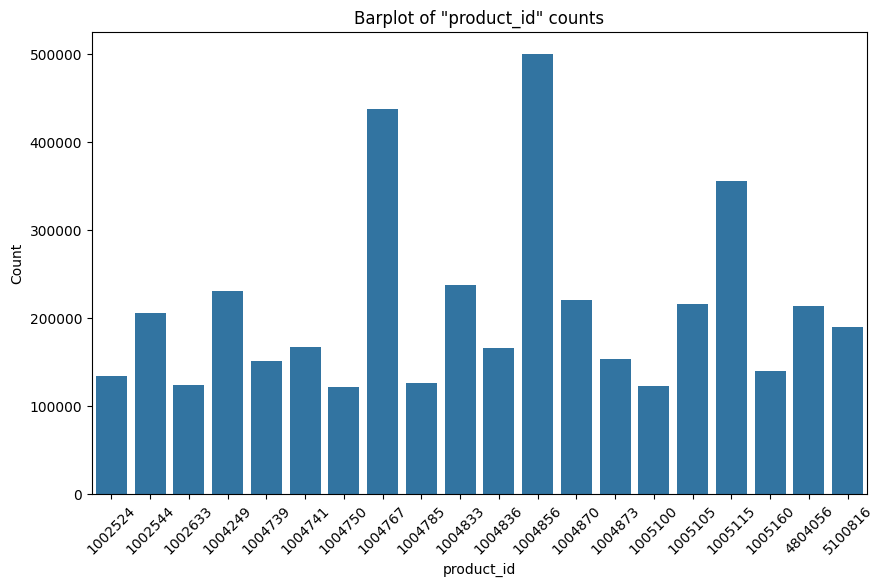

In [29]:
plot_cat_distribution(data=df, column_name="product_id")

In [30]:
(
    df
    .groupBy("product_id")
    .count()
    .orderBy("count", ascending=False)
    .show()
)

+----------+------+
|product_id| count|
+----------+------+
|   1004856|500354|
|   1004767|438232|
|   1005115|355786|
|   1004833|237545|
|   1004249|231070|
|   1004870|220501|
|   1005105|215598|
|   4804056|214234|
|   1002544|205597|
|   5100816|189460|
|   1004741|167491|
|   1004836|165769|
|   1004873|153992|
|   1004739|150870|
|   1005160|139673|
|   1002524|134206|
|   1004785|126394|
|   1002633|123521|
|   1005100|122286|
|   1004750|121626|
+----------+------+
only showing top 20 rows



In [31]:
df.filter(col("product_id") == "1004856").show()

+----------+--------------------+----------+--------------------+-------+------+------+-----------+
|product_id|          event_time|event_type|       category_code|  brand| price|amount|PrefHalfDay|
+----------+--------------------+----------+--------------------+-------+------+------+-----------+
|   1004856|2019-10-02 14:26:...|      view|electronics.smart...|samsung|130.25|500354|          2|
|   1004856|2019-10-02 14:27:...|      view|electronics.smart...|samsung|130.25|500354|          2|
|   1004856|2019-10-02 14:27:...|      view|electronics.smart...|samsung|130.25|500354|          2|
|   1004856|2019-10-02 14:27:...|      view|electronics.smart...|samsung|130.25|500354|          2|
|   1004856|2019-10-02 14:27:...|      view|electronics.smart...|samsung|130.25|500354|          2|
|   1004856|2019-10-02 14:27:...|      view|electronics.smart...|samsung|130.25|500354|          2|
|   1004856|2019-10-02 14:27:...|      view|electronics.smart...|samsung|130.25|500354|          2|


In [58]:
df = result_df.dropDuplicates(["product_id"])
df = df.drop("event_type", "event_time")
df.show()


+----------+--------------------+-------+------+------+-----------+
|product_id|       category_code|  brand| price|amount|PrefHalfDay|
+----------+--------------------+-------+------+------+-----------+
|   1002666|electronics.smart...|  honor|231.64|   417|          2|
|   1003023|electronics.smart...|    htc|126.13|     8|          2|
|   1003051|electronics.smart...|samsung|599.66|   155|          2|
|   1003079|electronics.smart...| huawei|180.16|    22|          1|
|   1003112|electronics.smart...|   sony|141.99|   706|          2|
|   1003159|electronics.smart...|   sony|123.56|    60|          2|
|   1003176|electronics.smart...| xiaomi|434.74|  3332|          2|
|   1003333|electronics.smart...|  apple|617.49|    44|          2|
|   1003372|electronics.smart...|   sony|411.31|   136|          2|
|   1003523|electronics.smart...|    zte|128.65|  2125|          2|
|   1003599|electronics.smart...|   NULL| 192.8|  3624|          2|
|   1003610|electronics.smart...|  meizu| 118.9|

In [59]:
df.count()

166794

CATEGORY_CODE

Количество категорий признака category_code: 127


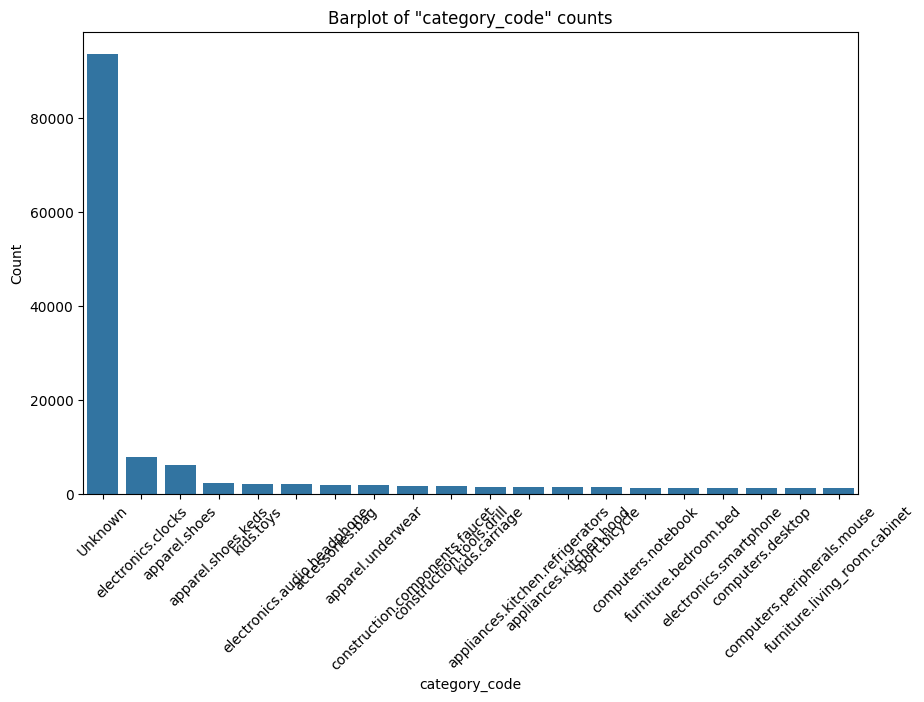

In [36]:
plot_cat_distribution(data=df, column_name="category_code")

In [37]:
df.show()

+----------+--------------------+-------+------+------+-----------+
|product_id|       category_code|  brand| price|amount|PrefHalfDay|
+----------+--------------------+-------+------+------+-----------+
|   1002666|electronics.smart...|  honor|231.64|   417|          2|
|   1003023|electronics.smart...|    htc|126.13|     8|          2|
|   1003051|electronics.smart...|samsung|599.66|   155|          2|
|   1003079|electronics.smart...| huawei|180.16|    22|          1|
|   1003112|electronics.smart...|   sony|141.99|   706|          2|
|   1003159|electronics.smart...|   sony|123.56|    60|          2|
|   1003176|electronics.smart...| xiaomi|434.74|  3332|          2|
|   1003333|electronics.smart...|  apple|617.49|    44|          2|
|   1003372|electronics.smart...|   sony|411.31|   136|          2|
|   1003523|electronics.smart...|    zte|128.65|  2125|          2|
|   1003599|electronics.smart...|   NULL| 192.8|  3624|          2|
|   1003610|electronics.smart...|  meizu| 118.9|

BRAND

In [38]:
count_nulls(data=df, column_name="brand")

Число колонок с NULL: 46277 (27.74%)


In [60]:
df = df.fillna({"brand": "Unidentified"})
count_nulls(data=df, column_name="brand")

Число колонок с NULL: 0 (0.00%)


Количество категорий признака brand: 3387


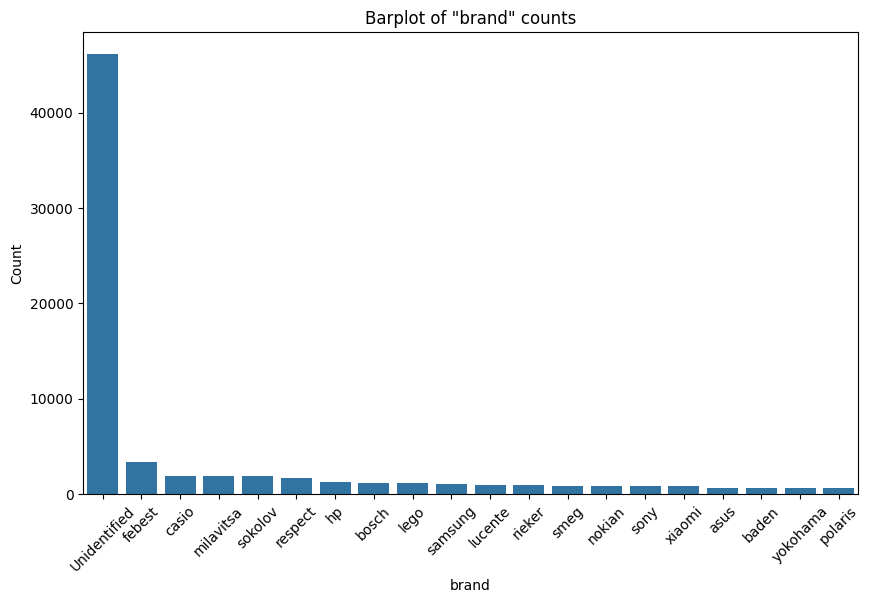

In [40]:
plot_cat_distribution(data=df, column_name="brand")

PRICE

In [41]:
count_nulls(data=df, column_name="price")

Число колонок с NULL: 0 (0.00%)


In [42]:
def plot_boxplots(data: DataFrame,
                  columns: list[str],
                  sample_fraction: float = 0.1) -> None:
    """
    Построение boxplot для нескольких столбцов в PySpark DataFrame.

    Args:
        data (DataFrame): DataFrame, содержащий данные.
        columns (list of str): Список имен столбцов для построения boxplot.
        sample_fraction (float): Доля данных для семплирования выбросов.
    
    Returns:
        None
    """
    box_data = []

    for column in columns:
        # Вычисление квантилей
        quantiles = data.approxQuantile(column, [0.25, 0.5, 0.75], 0.01)
        q1, median, q3 = quantiles

        # Вычисление IQR и границ усов
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        # Фильтрация выбросов
        filtered_df = data.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))
        outliers_df = data.filter((col(column) < lower_bound) | (col(column) > upper_bound))

        # Вычисление минимального и максимального значений
        min_value = data.agg({column: "min"}).collect()[0][0]
        mean_value = data.agg({column: "mean"}).collect()[0][0]
        std_value = data.agg({column: "std"}).collect()[0][0]
        max_value = data.agg({column: "max"}).collect()[0][0]

        # Ограничение усов минимальным и максимальным значениями
        lower_bound = max(lower_bound, min_value)
        upper_bound = min(upper_bound, max_value)

        # Семплирование выбросов
        outliers = []
        if not outliers_df.isEmpty():
            sampled_outliers_df = outliers_df.sample(sample_fraction)
            outliers = (
                sampled_outliers_df
                .select(column)
                .limit(1000)
                .collect()
            )
            outliers = [row[column] for row in outliers]
            
            # Добавление минимального и максимального значений, если они 
            # относятся к выбросам и не присутствуют в семпле
            if min_value < lower_bound and min_value not in outliers:
                outliers.append(min_value)
            if max_value > upper_bound and max_value not in outliers:
                outliers.append(max_value)

        # Подготовка данных для axes.bxp
        box_data.append({
            'whislo': lower_bound,  # Нижняя граница усов
            'q1': q1,               # Первый квартиль
            'med': median,          # Медиана
            'q3': q3,               # Третий квартиль
            'whishi': upper_bound,  # Верхняя граница усов
            'fliers': outliers      # Выбросы
        })
        
    # Вывод статистических характеристик
    print(f"Минимальное значение:          {min_value:.2f}")
    print(f"Среднее значение:              {mean_value:.2f}")
    print(f"Среднеквадратичное отклонение: {std_value:.2f}")
    print(f"Первый квартиль:               {q1:.2f}")
    print(f"Медиана:                       {median:.2f}")
    print(f"Третий квартиль:               {q3:.2f}")
    print(f"Максимальное значение:         {max_value:.2f}")

    # Построение boxplot
    fig, ax = plt.subplots(figsize=(20, 6))
    ax.bxp(box_data, 
           vert=False, 
           positions=range(1, len(columns) + 1), widths=0.5)
    ax.set_yticks(range(1, len(columns) + 1))
    ax.set_yticklabels(columns)
    ax.set_xlabel('Value')
    ax.set_title('Boxplots')
    ax.grid(True)
    plt.show()

Минимальное значение:          0.00
Среднее значение:              168.58
Среднеквадратичное отклонение: 289.98
Первый квартиль:               20.61
Медиана:                       64.61
Третий квартиль:               171.74
Максимальное значение:         2574.07


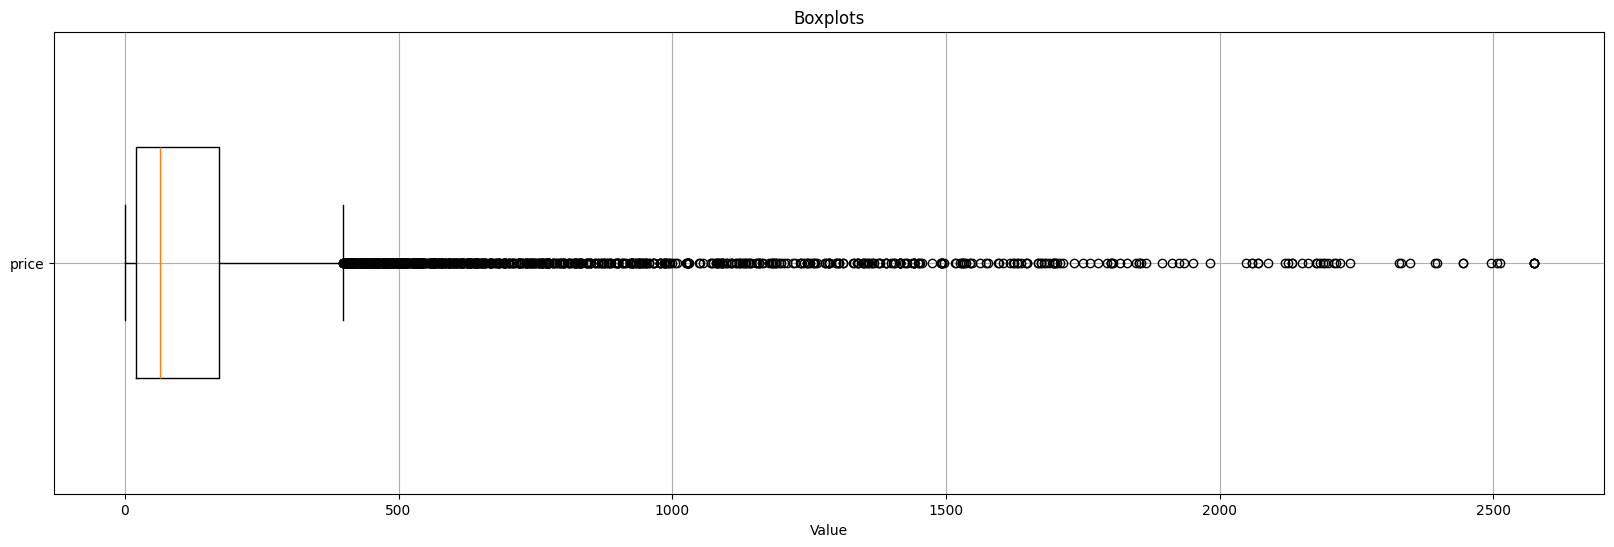

In [43]:
plot_boxplots(data=df, columns=["price"])

In [44]:
def plot_quant_distribution(data: DataFrame,
                            column: str,
                            num_bins: int = 200) -> None:
    """
    Построение гистограммы для количественной переменной с 
    использованием PySpark и Seaborn.

    Args:
        data (DataFrame): DataFrame с данными.
        column_name (str): Название колонки с количественной переменной.
        num_bins (int): Количество бинов для гистограммы.

    Returns:
        None
    """
    # Находим минимальное и максимальное значения колонки
    min_value = data.agg({column: "min"}).collect()[0][0]
    max_value = data.agg({column: "max"}).collect()[0][0]

    # Размер бина
    bin_size = (max_value - min_value) / num_bins

    # Добавляем колонку с номером бина
    data = data.withColumn(
        "bin", 
        floor((col(column) - min_value) / bin_size)
    )

    # Группируем по номеру бина и считаем количество строк в каждом бине
    bin_counts = data.groupBy("bin").count()

    # Преобразуем результат в Pandas DataFrame для построения гистограммы
    bin_counts_pd = bin_counts.limit(1000).toPandas()
    
    # Создаем массив границ бинов
    bin_edges = [min_value + i * bin_size for i in range(num_bins + 2)]
    
    # Преобразуем номера бинов в центры бинов
    bin_centers = [
        (bin_edges[i] + bin_edges[i + 1]) / 2 for i in range(num_bins + 1)
    ]
    
    # Добавляем центры бинов в Pandas DataFrame
    bin_counts_pd['bin_center'] = bin_counts_pd['bin'].apply(
        lambda x: bin_centers[int(x)]
    )
    
    # Построение гистограммы с использованием Seaborn
    plt.figure(figsize=(20, 6))
    sns.histplot(data=bin_counts_pd, x="bin_center", 
                 weights="count", kde=True, bins=num_bins + 1)
    plt.xlabel("Value")
    plt.ylabel("Count")
    plt.title(f"Распределение количественного признака \"{column}\"")
    plt.grid(True)
    plt.show()

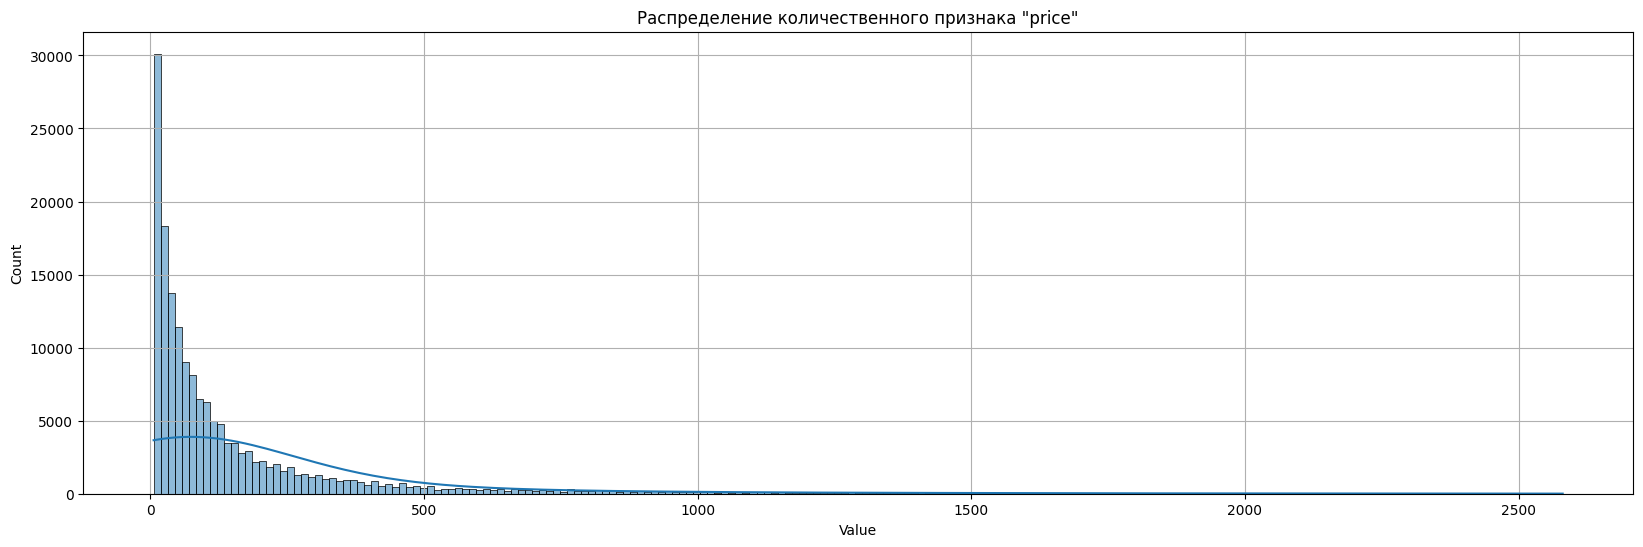

In [45]:
plot_quant_distribution(data=df, column="price")

In [61]:
df = df.withColumn(
    "price",
    when(col("price") > 1500, 1500)
        .otherwise(col("price"))
)

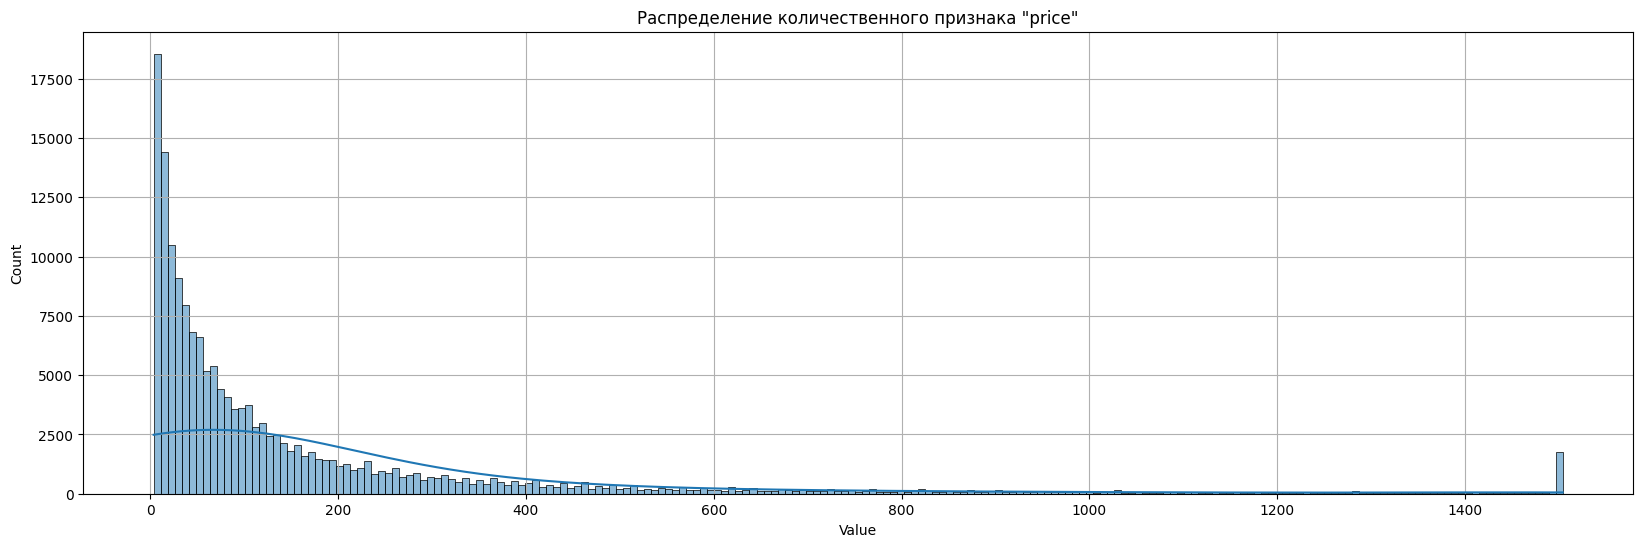

In [47]:
plot_quant_distribution(data=df, column="price")

AMOUNT

Минимальное значение:          1.00
Среднее значение:              254.50
Среднеквадратичное отклонение: 3046.37
Первый квартиль:               7.00
Медиана:                       25.00
Третий квартиль:               87.00
Максимальное значение:         500354.00


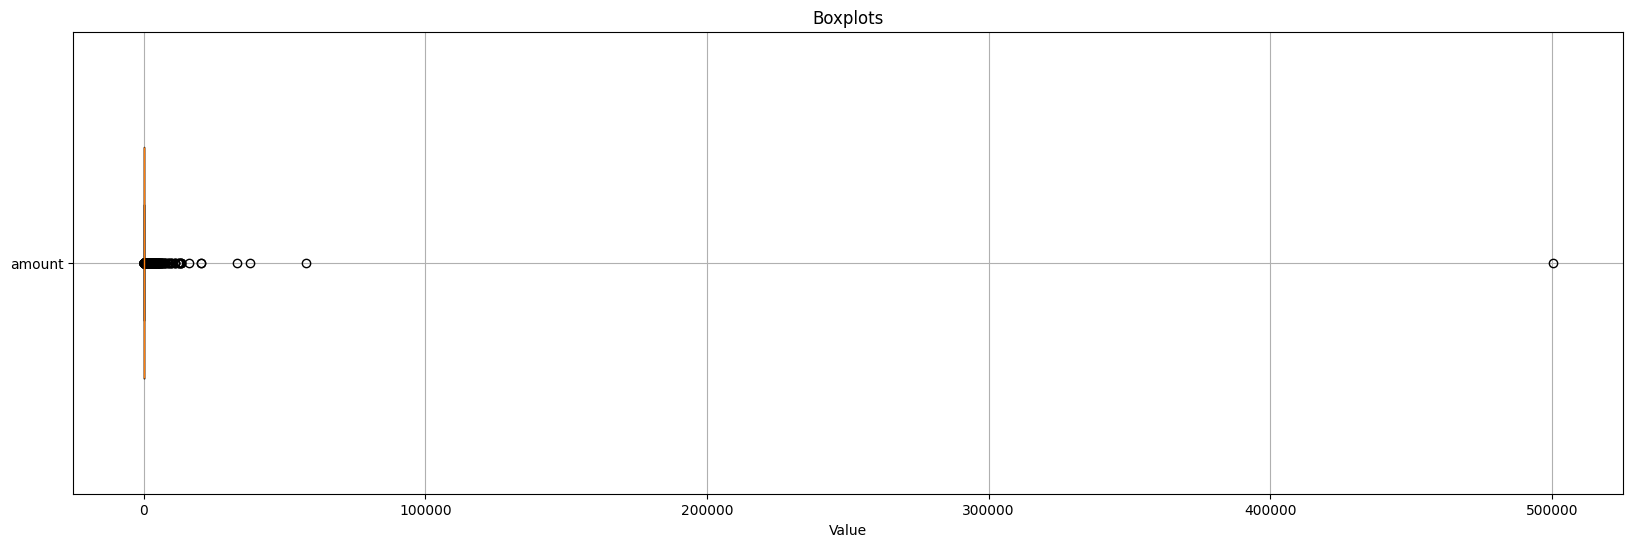

In [48]:
plot_boxplots(data=df, columns=["amount"])

In [77]:
df.filter(col("amount") > 1000).count()




6268

In [78]:
df1 = df.filter(col("amount") < 1000)

Минимальное значение:          1.00
Среднее значение:              80.99
Среднеквадратичное отклонение: 148.87
Первый квартиль:               6.00
Медиана:                       23.00
Третий квартиль:               74.00
Максимальное значение:         999.00


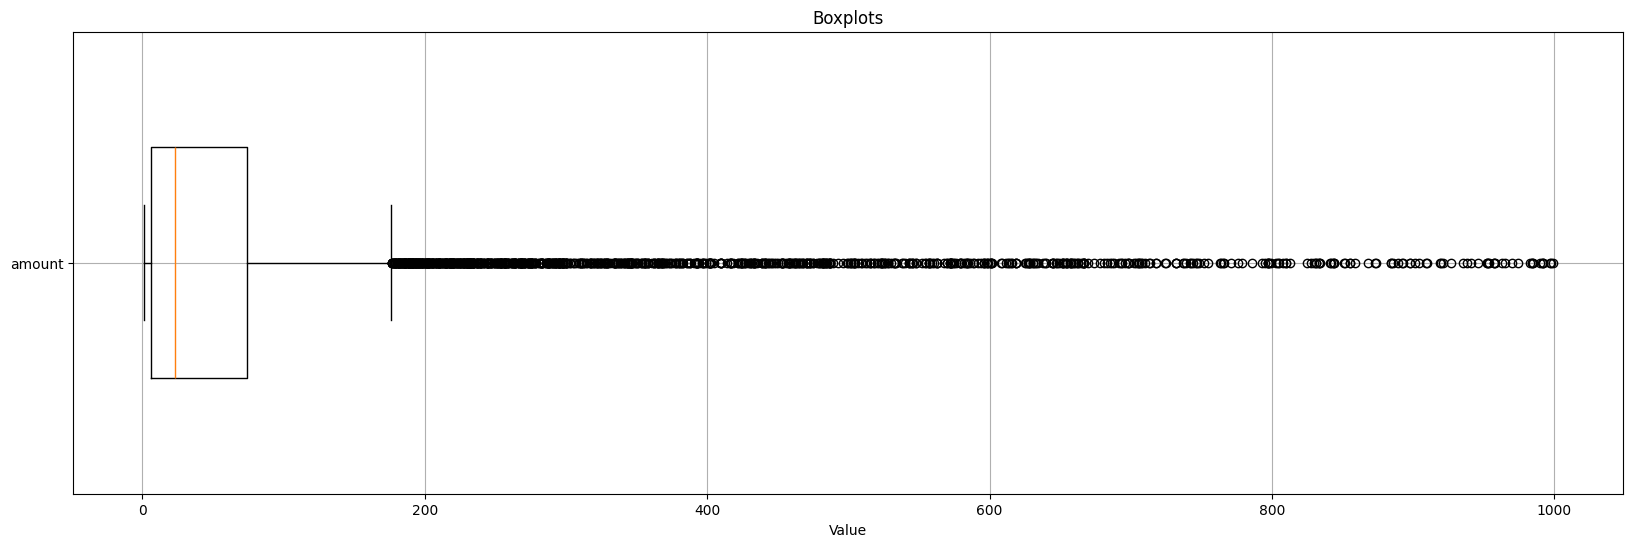

In [79]:
plot_boxplots(data=df1, columns=["amount"])

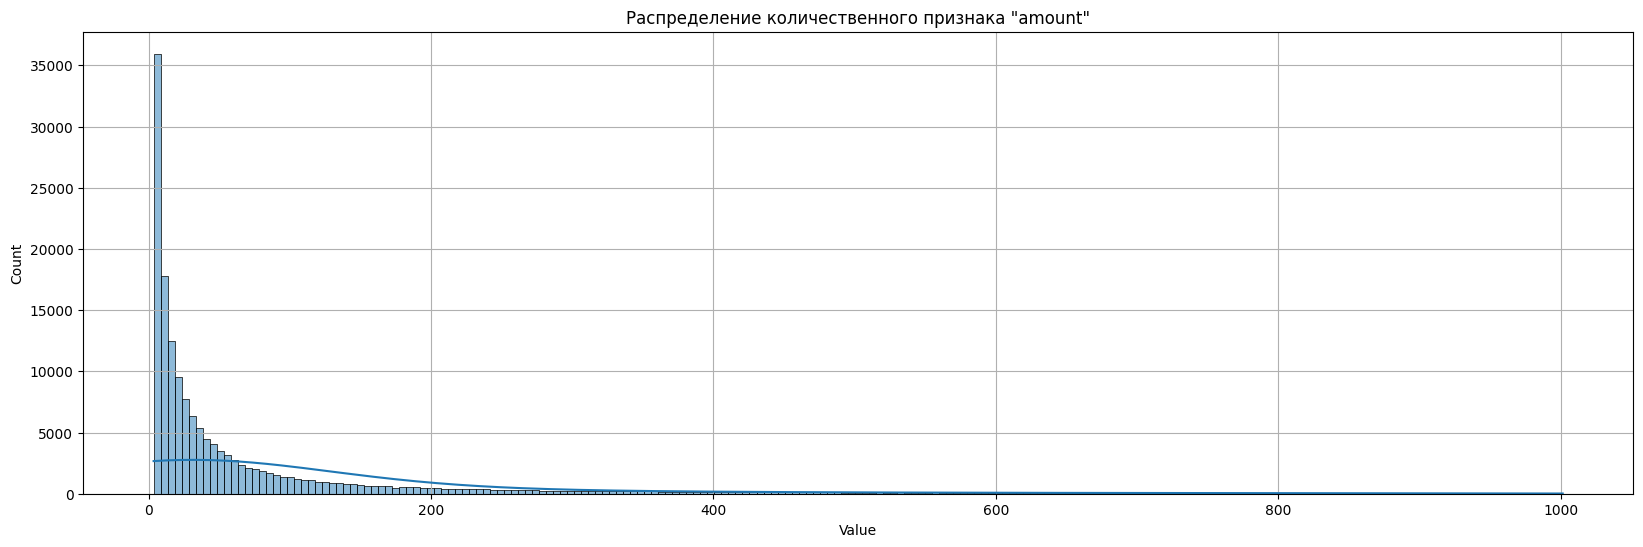

In [81]:
plot_quant_distribution(data=df1, column="amount")

In [82]:
def compute_and_visualize_correlation_matrix(data: DataFrame, 
                                             columns: list[str]) -> None:
    """
    Вычисляет и визуализирует корреляционную матрицу для указанных 
    колонок в DataFrame PySpark.

    Args:
        df (DataFrame): DataFrame PySpark.
        columns (list[str]): Список колонок для вычисления корреляции.

    Returns:
        None
    """
    # Вычисление корреляционной матрицы
    corr_matrix = {}
    for col1 in columns:
        corr_matrix[col1] = {}
        for col2 in columns:
            corr_value = data.select(corr(col1, col2)).collect()[0][0]
            corr_matrix[col1][col2] = corr_value

    # Преобразование корреляционной матрицы в DataFrame Pandas для визуализации
    corr_matrix_pd = pd.DataFrame(corr_matrix)

    # Построение и визуализация корреляционной матрицы
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix_pd, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.show()

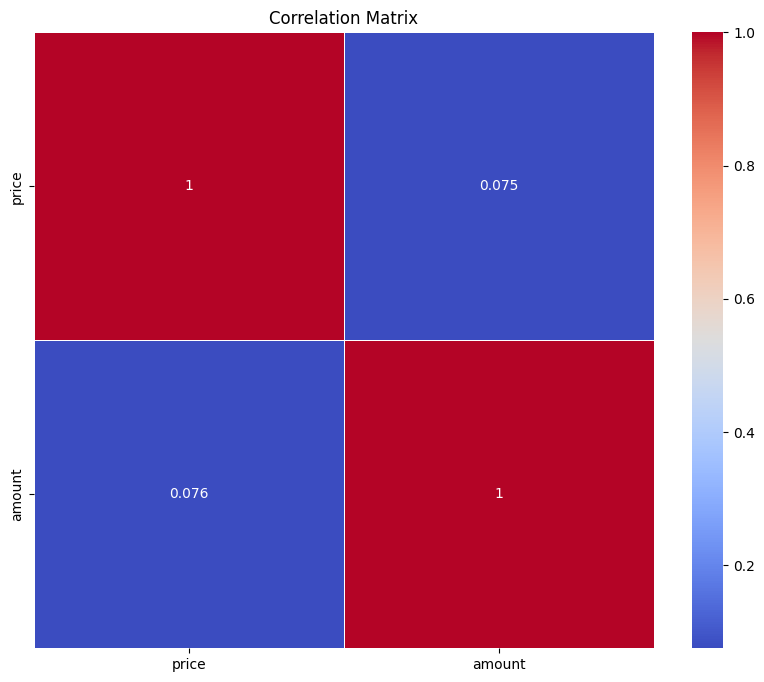

In [84]:
compute_and_visualize_correlation_matrix(
    data=df1, columns=[
        "price", "amount"
    ]
)

Количество категорий признака PrefHalfDay: 2


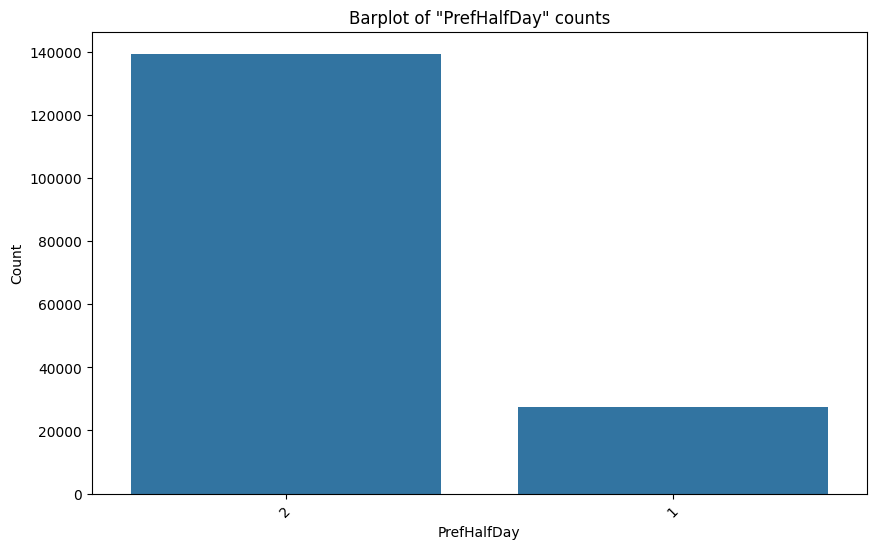

In [87]:
plot_cat_distribution(data=df, column_name="PrefHalfDay")

In [85]:
df1.show()

+----------+--------------------+----------+------+------+-----------+
|product_id|       category_code|     brand| price|amount|PrefHalfDay|
+----------+--------------------+----------+------+------+-----------+
|   1002666|electronics.smart...|     honor|231.64|   417|          2|
|   1003023|electronics.smart...|       htc|126.13|     8|          2|
|   1003051|electronics.smart...|   samsung|599.66|   155|          2|
|   1003079|electronics.smart...|    huawei|180.16|    22|          1|
|   1003112|electronics.smart...|      sony|141.99|   706|          2|
|   1003159|electronics.smart...|      sony|123.56|    60|          2|
|   1003333|electronics.smart...|     apple|617.49|    44|          2|
|   1003372|electronics.smart...|      sony|411.31|   136|          2|
|   1003610|electronics.smart...|     meizu| 118.9|    50|          2|
|   1003715|electronics.smart...|   samsung| 818.3|    13|          1|
|   1003723|electronics.smart...|   tp-link|128.45|     1|          1|
|   10

In [86]:
df1.count()

160520

In [81]:
#spark.sql("DROP TABLE spark_catalog.lopin_database1.sobd_lab1_processed_table")

DataFrame[]

In [89]:
# Сохранение DataFrame в виде таблицы
df1.writeTo("sobd_lab1_processed_table").using("iceberg").create()

24/12/16 01:32:09 WARN HadoopTableOperations: Error reading version hint file hdfs:/user/user1/warehouse/lopin_database1/sobd_lab1_processed_table/metadata/version-hint.text
java.io.FileNotFoundException: File does not exist: /user/user1/warehouse/lopin_database1/sobd_lab1_processed_table/metadata/version-hint.text
	at org.apache.hadoop.hdfs.server.namenode.INodeFile.valueOf(INodeFile.java:87)
	at org.apache.hadoop.hdfs.server.namenode.INodeFile.valueOf(INodeFile.java:77)
	at org.apache.hadoop.hdfs.server.namenode.FSDirStatAndListingOp.getBlockLocations(FSDirStatAndListingOp.java:159)
	at org.apache.hadoop.hdfs.server.namenode.FSNamesystem.getBlockLocations(FSNamesystem.java:2198)
	at org.apache.hadoop.hdfs.server.namenode.NameNodeRpcServer.getBlockLocations(NameNodeRpcServer.java:795)
	at org.apache.hadoop.hdfs.protocolPB.ClientNamenodeProtocolServerSideTranslatorPB.getBlockLocations(ClientNamenodeProtocolServerSideTranslatorPB.java:468)
	at org.apache.hadoop.hdfs.protocol.proto.Clien

In [90]:
for table in spark.catalog.listTables():
    print(table.name)

sobd_lab1_processed_table
sobd_lab1_table


In [91]:
spark.stop()